# Многорукие бандиты для задачи блокировок РКО счета после его открытия в течение 6ти месяцев.

Цель состоит в том, чтобы создать автоматическую систему обучения с подкреплением для управления системой открытия счета РКО для клиента.
Идея состоит в том, клиент обращается в банк для открытия РКО счета, однако это может быть фиктивное открытие, которое заблокируется в течение 60 дней. На основе истории о клиенте мы можем понять заблокируется счет РКО или нет, система открывает счет (действие 1) или не открывает (действие 0).
Поэтому система обучения с подкреплением имеет **два возможных действия**.

С другой стороны, полученная награда:

- 0, если система не открывает счет РКО
- 1, если система открывает счет РКО и он **не блокируется**
- -10, если система открывает счет РКО и он **блокируется**

In [1]:
#!pip install pandas scikit-learn category_encoders space_bandits contextualbandits tqdm numpy matplotlib pyyaml seaborn

In [2]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from category_encoders import CatBoostEncoder

from space_bandits import LinearBandits

from sklearn.linear_model import LogisticRegression
from copy import deepcopy

from tqdm import tqdm
import yaml
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
from pylab import rcParams

%matplotlib inline
matplotlib.rc('figure', figsize=(15, 4))

import warnings

pd.options.display.max_colwidth = 200
warnings.filterwarnings("ignore")

SEED = 42

/opt/anaconda3/envs/work/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(SEED)

In [4]:
df = pd.read_csv("./data/df_train.csv")
print(df.shape)
print(df.target.mean())
df.head(2)

(52049, 83)
0.11297047013391227


,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,NaN,0,0,0,1,2,4,4,3,1
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,NaN,0,2,1,0,0,1,0,0,5


In [5]:
key_cols = ['inn','data_zajavki']
target = 'target'
df.head(2)

,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,NaN,0,0,0,1,2,4,4,3,1
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,NaN,0,2,1,0,0,1,0,0,5


In [6]:
df.isna().sum()

idinquiry           0
time_zajavki        0
tip_organizatsii    0
data_zajavki        0
year_mon_zajavki    0
                   ..
kmeans_6            0
kmeans_7            0
kmeans_8            0
kmeans_9            0
kmeans_10           0
Length: 83, dtype: int64

In [7]:
with open(r'./data/features.yaml', 'r') as f:
    dict_features = yaml.load(f, Loader=yaml.Loader)
num_cols = dict_features['cont_features']
cat_cols = dict_features['cat_features']

feat_cols = num_cols+cat_cols

print(len(num_cols),len(cat_cols))

16 24


In [8]:
### Предобработчик признаков

class SentColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns: list=None) -> None:
        self.columns = columns
    
    def fit(self, X:pd.DataFrame=None, y:pd.DataFrame=None):
        return self

    def transform(self, X:pd.DataFrame=None)->pd.DataFrame:
        df_x = pd.DataFrame(X)
        df_x.columns = self.columns
        return df_x
    
def base_pipe(num_columns:list=None, cat_columns:list=None, fill_value:float=-1e24)->object:

    # создаем конвейер для количественных переменных
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value = fill_value)),
        ('scaler', StandardScaler())
    ])

    # создаем конвейер для категориальных переменных
    cat_pipe = Pipeline([
        ('catenc', CatBoostEncoder(cols=cat_columns))
    ])

    transformers = [('num', num_pipe, num_columns),
                    ('cat', cat_pipe, cat_columns)]

    # передаем список трансформеров в ColumnTransformer
    transformer = ColumnTransformer(transformers=transformers)

    # задаем итоговый конвейер
    prep_pipe = Pipeline([
        ('transform', transformer),
        ('sent_columns', SentColumns(columns=num_columns+cat_columns))
    ])  

    return prep_pipe

In [9]:
data_prepared = base_pipe(num_columns=num_cols,
                          cat_columns=cat_cols).fit_transform(df,
                                                              df[target]).reset_index(drop=True)
df[num_cols+cat_cols] = data_prepared[num_cols+cat_cols]
df.head(2)

,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
0,149105,2018-06-18 03:37:00.000000,ЮЛ,2018-06-18,2018-06,2018Q2,2018,BYKKBSYFTS,2018-06-18 03:34:03.993000,2.0,...,-0.395848,0.112970,0,0,0.11297,2,4,4,0.11297,0.11297
1,149107,2018-06-18 03:49:00.000000,ИП,2018-06-18,2018-06,2018Q2,2018,MIWYERAPTINW,2018-06-18 03:46:46.243000,0.0,...,-0.395848,0.056485,2,1,0.11297,0,1,0,0.11297,0.11297


In [10]:
df.describe().T.round(2).astype(str)

,count,mean,std,min,25%,50%,75%,max
idinquiry,52049.0,241118.87,62620.52,149105.0,196410.0,238279.0,278701.0,622432.0
year_zajavki,52049.0,2018.53,0.5,2018.0,2018.0,2019.0,2019.0,2019.0
kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,51788.0,0.93,1.79,0.0,0.0,1.0,1.0,75.0
kompanija_vhodit_v_juridicheskie_litsa_v_sostav_ispolnitel_nyh_organov_kotoryh_vhodjat_diskvalifitsirovannye_litsa,52049.0,0.07,0.04,0.01,0.03,0.08,0.1,0.22
kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns,52049.0,-0.0,1.0,-1.06,-1.06,0.95,0.95,0.95
kolichestvo_vidov_dejatel_nosti_u_klienta,52049.0,0.0,1.0,-17.12,0.06,0.06,0.06,0.06
kod_osnovnogo_okved,52049.0,0.08,0.07,0.0,0.02,0.06,0.12,0.78
sub_ekt_mestonahozhdenija,52049.0,0.08,0.06,0.0,0.03,0.06,0.11,0.7
razmer_ustavnogo_kapital_jul,52049.0,-0.0,1.0,-1.04,-1.04,0.97,0.97,0.97
chistaja_pribyl_ili_ubytok_kompanii,52049.0,-0.0,1.0,-0.48,-0.48,-0.48,-0.48,2.08


Столбец **target** имеет значение 0, если у клиента не блокируется счет РКО, и 1, если счет блокируется.

Теперь разделим набор данных на обучающий и тестовый:

In [11]:
df_train, df_test = train_test_split(df, random_state=SEED, test_size=0.25, stratify=df["target"])

In [12]:
# доля таргета в обучающей и тестовой выборках:

df_train["target"].mean(), df_test["target"].mean()

(0.11297264063940977, 0.11296395911780527)

In [13]:
# Я определяю класс клиентов:

class clients:
    def __init__(self, df, context, target, penalty=-10): # self: внутренние параметры
        """
        Класс клиентов, открывающих счет РКО
            df: выборка
            context: факторы по клиенту
            target: целевая переменная
            penalty: штраф
        """
        self.i = -1
        self.df = df
        self.context = context
        self.target = target
        self.penalty = penalty
    def clients(self):
        """
        Функция имитации прибытия клиента
        """
        self.i = self.i + 1
        if self.i == len(self.df):
            self.i = 0
    def get_context(self):
        """
        Функция, которая извлекает контекст по клиенту
        """
        return self.df.iloc[self.i][self.context]
    def get_reward(self, action):
        """
        Функция, которая рассчитывает reward (вознаграждение) по клиенту
            action: действие, где 1 - открываем счет, 0 - не открываем счет
        """
        if action==0:
            return 0
        if self.df.iloc[self.i][self.target] == 1: # если счет заблокируется
            return self.penalty
        return 1 # если счет не заблокируется
    
    def getBestReward(self):
        return max(self.get_reward(0), self.get_reward(1))

In [14]:
# Опрледелим экземпляры класса

cl_train = clients(df=df_train, context=feat_cols, target=target, penalty=-10)
cl_test  = clients(df=df_test, context=feat_cols, target=target, penalty=-10)

In [15]:
# Прибытие одного клиента

cl_train.clients()

In [16]:
cl_train.get_context()

_kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione                                                             0.070991
passivy_vsego                                                                                                                -0.529605
kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns                               0.946536
diff_req_open                                                                                                                -0.468638
kolichestvo_vidov_dejatel_nosti_u_klienta                                                                                     0.058414
tax_profit                                                                                                                   -0.395848
summa_naloga                                                                                                                 -0.396952
kolichestvo_filialov                                   

In [17]:
cl_train.get_reward(0)

0

In [18]:
cl_train.getBestReward()

1

# **План решения задачи многоруких бандитов**

### Задача 1. Рассчитайте эволюцию общего reward и общего regret при обучении:
1. Случайный алгоритм
2. Алгоритм, который всегда открывает счет
3. Алгоритм, который никогда не открывает счет

In [19]:
available_actions = [0, 1] # Открыть или не открыть счет

In [20]:
def makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean):
    plt.subplot(1,2,1)
    plt.plot(reward_mean, label = 'Reward mean', c = 'red')
    plt.plot(regret_mean, label = 'Regret mean', c = 'blue')
    plt.title("Эволюция среднего Reward и Regret")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(reward_total_vec, label = 'Reward total', c = 'red')
    plt.plot(regret_total_vec, label = 'Regret total', c = 'blue')
    plt.title("Эволюция общей суммы Reward и Regred")
    plt.legend()
    plt.grid()

#### 1. Случайный алгоритм

In [21]:
N = 10_000

100%|██████████| 10000/10000 [00:05<00:00, 1982.92it/s]


Reward mean: -0.1349
Regret mean: 1.0231


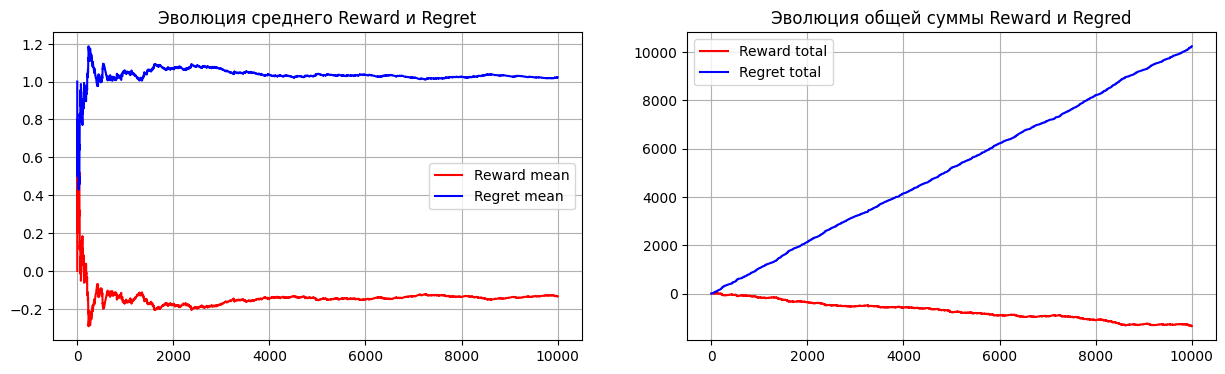

In [22]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

for i in tqdm(range(N)):
    cl_train.clients()
    action = np.random.choice(len(available_actions))
    reward = cl_train.get_reward(action)
    reward_total += reward
    regret = cl_train.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)


print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- Полученные графики представляют случайное поведение (что является отправной точкой).
- Полученные графики являются ожидаемыми, имеющими в среднем гораздо большее Regret, чем Reward, это связано с тем, что открывать счет РКО очень дорого (-10) если его заблокируют в течение 6 месяцев.

#### 2. Алгоритм, который всегда открывает счет РКО

100%|██████████| 10000/10000 [00:04<00:00, 2171.85it/s]


Reward mean: -0.2617
Regret mean: 1.147


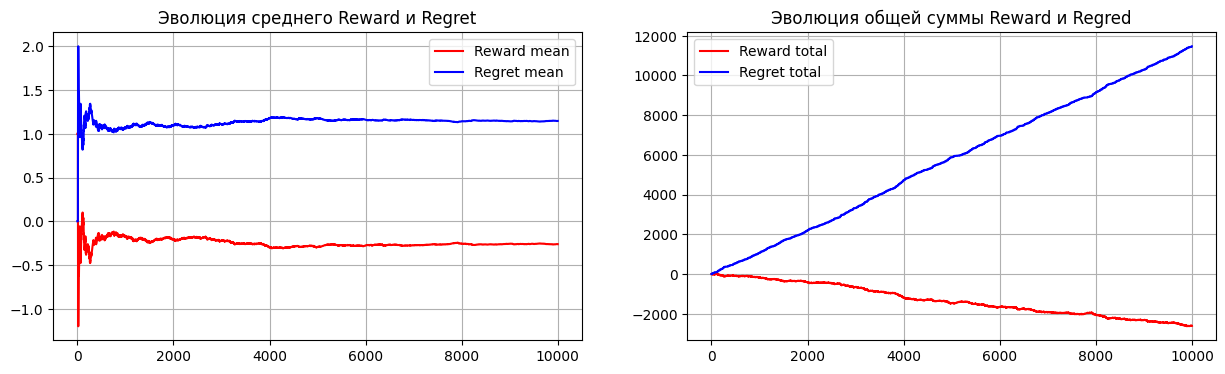

In [23]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

for i in tqdm(range(N)):
    cl_train.clients()
    action = 1 # Всегда открываем счет
    reward = cl_train.get_reward(action)
    reward_total += reward
    regret = cl_train.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)


print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- В этом случае видно, что среднее Reward немного выше по сравнению с тем, которое получается при выполнении случайных действий.
- В этом случае, всегда открывать счет РКО, мы видим, что это работает лучше, чем случайное поведение, однако в реальной жизни это не идеально.

#### 3. Алгоритм, который никогда не открывает счет РКО

100%|██████████| 10000/10000 [00:02<00:00, 3633.92it/s]


Reward mean: 0.0
Regret mean: 0.8874


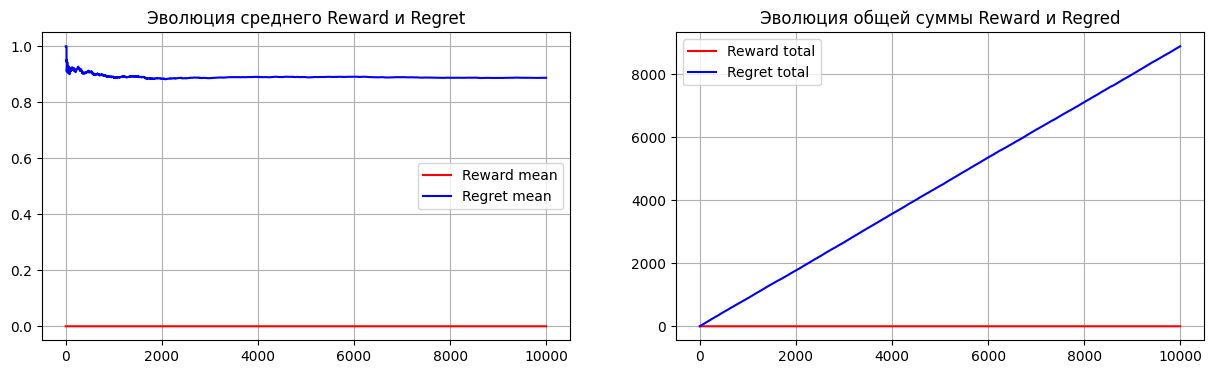

In [24]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

for i in tqdm(range(N)):
    cl_train.clients()
    action = 0 # Никогда открываем счет
    reward = cl_train.get_reward(action)
    reward_total += reward
    regret = cl_train.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)


print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- Полученные графики имеют большой смысл, поскольку среднее Reward равно нулю, поскольку счет никогда не открывается. В то время как Regret стабилизируется на уровне 1.

### Задача 2: 
##### Обучить **неконтекстуального** многорукого бандита на тренировке. Рассчитать те же метрики, что и в пункте 1.

* Реализуется неконтекстный $\epsilon$-жадный алгоритм с затуханием.

In [25]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.Qs = -10*np.ones(n_arms)

    def choose_action(self):
        if np.random.rand() < self.epsilon: # Мы исследовали?
            return np.random.choice(self.n_arms)
        return np.argmax(self.Qs)
    
    def update(self, action, r): # с помощью этой функции агент «обучается»
        self.counts[action] += 1 # прибавляем 1 к количеству раз выполнения действия «действие»
        self.values[action] += r # мы добавляем r к общей награде, связанной с этим действием
        self.Qs[action] = self.values[action] / self.counts[action] # мы пересчитываем Q

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

Проведем обучение бесконтекстного агента $\epsilon$-жадного. В отличие от предыдущих алгоритмов, на этот раз модель учится предпринимать наилучшие действия (которые максимизируют $Q(a)$).

100%|██████████| 10000/10000 [00:03<00:00, 2508.98it/s]


Reward mean: -0.0329
Regret mean: 0.9202
Agent: 
 - Qs: [ 0.         -0.13055556]
 - N действий: [7480. 2520.]
 - Total Rewards: [   0. -329.]


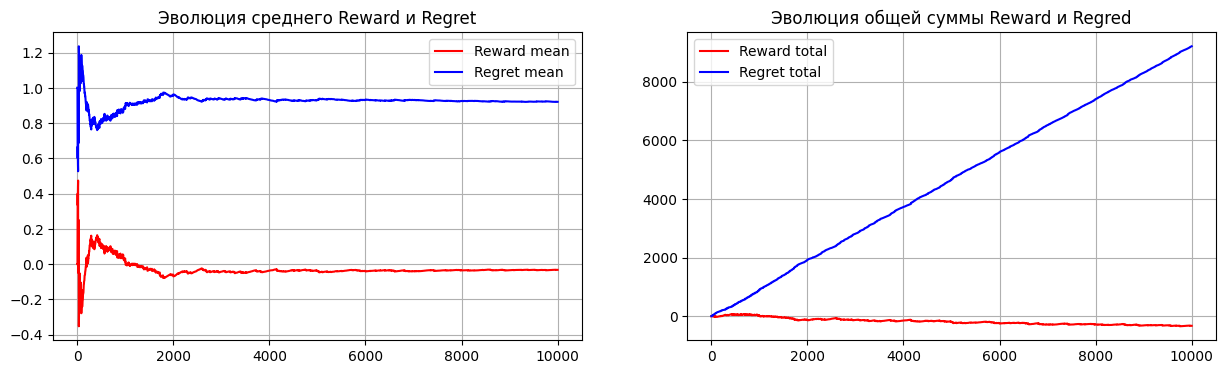

In [26]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

# Agente no contextual
agent = EpsilonGreedy(epsilon=0.7, n_arms=len(available_actions))
decay_rate = 0.9999 # скорость потухания

for i in tqdm(range(N)):
    cl_train.clients()

    # Выбираем действие по жадному
    action = agent.choose_action()
    reward = cl_train.get_reward(action)

    # Обновляем Q агента
    agent.update(action, reward)

    reward_total += reward
    regret = cl_train.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)

    # Decaying epsilon
    agent.set_epsilon(agent.epsilon*decay_rate)

print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
print(f"Agent: \n - Qs: {agent.Qs}\n - N действий: {agent.counts}\n - Total Rewards: {agent.values}")
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- В начале алгоритм всегда исследует (epsilon=1), а потом только эксплуатирует. Со временем алгоритм понимает, что открывать счет РКО в среднем лучше, чем не открывать.
- Среднее вознаграждение данного алгоритма в случае открытия РКО ниже, чем если бы мы всегда открывали, не подкрепляя никаким исследованием

### Задание 3: Обучить линейного контекстного многорукого бандита на тренировке. Рассчитайте те же метрики, что и в предыдущих пунктах.

In [27]:
n_feats = len(feat_cols)
print('Features: {}\n\nn_Features: {}'.format(feat_cols, n_feats))

Features: ['_kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione', 'passivy_vsego', 'kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns', 'diff_req_open', 'kolichestvo_vidov_dejatel_nosti_u_klienta', 'tax_profit', 'summa_naloga', 'kolichestvo_filialov', 'vyruchka_kompanii_mln_rub_', 'ros', 'roa', 'razmer_ustavnogo_kapital_jul', 'chistaja_pribyl_ili_ubytok_kompanii', 'kolichestvo_change_rukovoditelja', '_kolichestvo_kompanij_s_analogichnym_direktorom', 'kolichestvo_souchreditelej', 'kmeans_5', 'indeks_dolzhnoj_osmotritel_nosti', '_organizatsija_pervoe_litso_uchrediteli_vhodit_v_spisok_diskvalifitsirovannyh_', 'indeks_finansovogo_riska', 'more_one_open', 'chislennost_kompanii', 'kmeans_2', 'more_one_close', 'sub_ekt_mestonahozhdenija', 'kredity', 'more_one_req_q', 'data_registratsii', '_massovyj_kontaktnyj_telefon_v_zajavke_ukazan_telefon_na_kotoryj_zaregistrirovano_bolee_h_kompanij_krome_kompanij_agentov_', 'kompanija_vhodit_v_ju

100%|██████████| 10000/10000 [01:16<00:00, 131.39it/s]


Reward mean: 0.2653
Regret mean: 0.6235


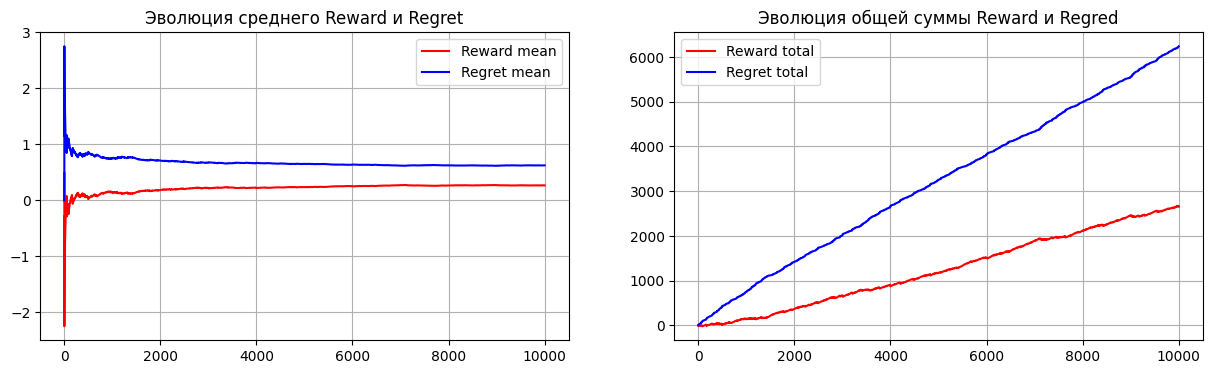

In [28]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

# Agente contextual lineal
agent = LinearBandits(len(available_actions), n_feats, initial_pulls=100)

for i in tqdm(range(N)):
    cl_train.clients()

    # Мы получаем контекст
    context = cl_train.get_context()

    # Выбираем действие по контексту
    action = agent.action(np.array(context))
    reward = cl_train.get_reward(action)

    # Обновляем модель
    agent.update(context, action, reward)

    reward_total += reward
    regret = cl_train.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)

print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- В этом случае видно, что при использовании линейной модели, основанной на контексте, результаты получаются значительно выше, чем у предыдущих алгоритмов.
- Модель, щная контекст каждого клиента, может сделать вывод открывать счет или нет, получая высокое значение Reward

### Задача 4. Рассчитайте для некоторых обучающих клиентов Q, заданную моделью для каждого действия. Проверьте, получаются ли у вас одинаковые значения, рассчитав их самостоятельно. Проверьте, является ли действие, выбранное моделью, самым высоким Q.

Ниже приведены Q, полученные с помощью модели:

In [29]:
linear_Qs = agent.mu
linear_Qs

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]),
 array([-0.01999367, -0.09896522,  0.06856475, -0.11708733,  0.16305238,
        -0.43256273,  0.41310873,  0.06856475, -0.06652992,  0.27783024,
         3.56614699, -0.30632106, -3.59151344, -0.01864081,  0.06856475,
         0.06856475,  5.27859944, -1.89136135,  3.04424284, -4.7839614 ,
        -1.66103353, -1.89322439,  3.07200212, -6.10773939, -2.02998316,
        -2.64593254, -0.79051741, -3.66287142,  0.04765845,  2.66537668,
         2.9680364 , -4.48262851,  7.28236716, -0.81335618,  2.83859657,
        -1.342047  , -2.90698983,  2.1988403 , -5.02366846, -0.57917347,
         0.84889515])]

**Расчет Q для первого клиента:**

In [30]:
cl_train.clients()
context = cl_train.get_context()
print('Id: {}\nContexto: \n{}'.format(cl_train.i, context))

Id: 10965
Contexto: 
_kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione                                                             0.070991
passivy_vsego                                                                                                                 1.888201
kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns                               0.946536
diff_req_open                                                                                                                -0.468638
kolichestvo_vidov_dejatel_nosti_u_klienta                                                                                     0.058414
tax_profit                                                                                                                     2.52622
summa_naloga                                                                                                                  2.519199
kolichestvo_filialov              

Ожидаемая стоимость модели:

В этом случае кредит будет предоставлен клиенту.

In [31]:
print('Qs оценивается по модели:',agent.expected_values(np.array(context)))

Qs оценивается по модели: [0.         1.19605661]


Ручной расчет:

Важно отметить, что Q модели имеют размерности [2, 11], поскольку последнее значение соответствует пересечению линейной модели (у нас есть 10 контекстных переменных). Можно отметить, что мы вручную получили тот же результат, что и модель.

In [32]:
# Q имеет 11 значений, так как последнее значение соответствует перехвату
# поэтому мы инициализируем сумму qs с помощью перехвата
total_qs = [linear_Qs[0][len(context)],linear_Qs[1][len(context)]]
for i in range(len(available_actions)):
    for j in range(len(context)):
        total_qs[i]+=agent.mu[i][j]*context.iloc[j]
print('Вопросы, полученные вручную:',total_qs)

Вопросы, полученные вручную: [0.0, 1.1960566088499893]


Действие, которое предпринимает модель, — это не открывать счет РКО.

In [33]:
print('Действия, предпринятые моделью:',agent.action(np.array(context)))

Действия, предпринятые моделью: 1


### Задача 5: 
- Рассчитать производительность тестируемого алгоритма многорукого бандита. 
- Сравнить ее с тестовой контрольной группой (10% тестовых клиентов в качестве контрольной группы).

In [34]:
df_valid, df_control = train_test_split(df, random_state=SEED, test_size=0.1, stratify=df[target])

In [35]:
cl_valid = clients(df_valid, context=feat_cols, target=target)
cl_control = clients(df_control, context=feat_cols, target=target)

In [36]:
cl_valid.get_context()

_kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione                                                             0.070991
passivy_vsego                                                                                                                -0.529605
kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns                               0.946536
diff_req_open                                                                                                                -0.468638
kolichestvo_vidov_dejatel_nosti_u_klienta                                                                                     0.058414
tax_profit                                                                                                                   -0.395848
summa_naloga                                                                                                                 -0.396952
kolichestvo_filialov                                   

100%|██████████| 10000/10000 [00:39<00:00, 255.66it/s]


Reward mean: 0.3055
Regret mean: 0.5839


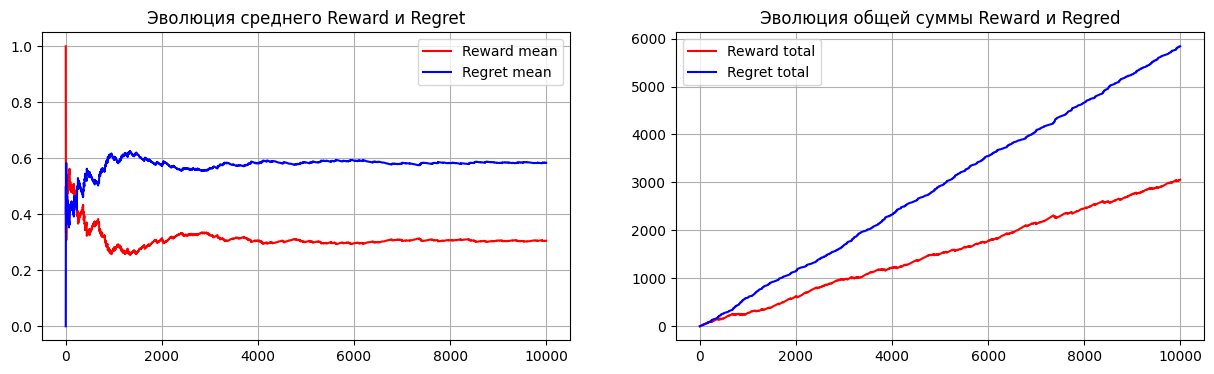

In [37]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

for i in tqdm(range(N)):
    cl_valid.clients()

    # Мы получаем контекст
    context = cl_valid.get_context()

    # Выбираем действие по контексту
    action = agent.action(np.array(context))
    reward = cl_valid.get_reward(action)

    # Обновляем модель
    reward_total += reward
    regret = cl_valid.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)

print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- Можно отметить, что качество модели сохраняется на данных валидации, даже среднее вознаграждение получается немного выше вознаграждения, полученного при обучении.

Теперь мы проведем эксперимент с контрольной группой (кредиты будут выдаваться случайным образом).

100%|██████████| 10000/10000 [00:04<00:00, 2113.54it/s]


Reward mean: -0.1005
Regret mean: 0.9875


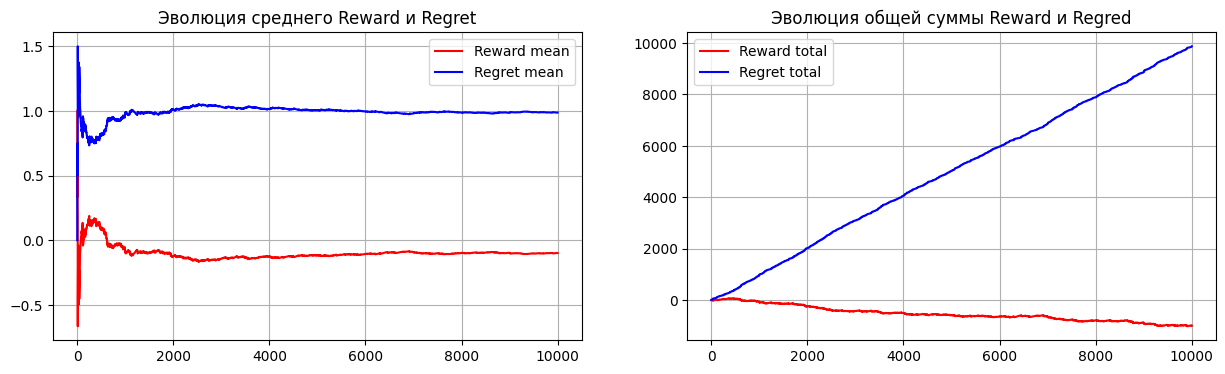

In [38]:
# Reward
reward_mean = []
reward_total = 0
reward_total_vec = []

#Regret
regret_mean = []
regret_total = 0
regret_total_vec = []

for i in tqdm(range(N)):
    cl_control.clients()
    action = np.random.choice(len(available_actions))
    reward = cl_control.get_reward(action)
    reward_total += reward
    regret = cl_control.getBestReward()-reward
    regret_total += regret
    reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
    reward_total_vec.append(reward_total)
    regret_mean.append(regret_total/(i+1))
    regret_total_vec.append(regret_total)


print("Reward mean:", reward_total/N)
print("Regret mean:", regret_total/N)
makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

**ВЫВОД:** 
- Видно, что при случайном предоставлении кредитов в контрольной группе результаты значительно ниже результатов, полученных с использованием ранее обученной модели, что показывает, что модель работает, максимизируя вознаграждение, полученное при выполнении соответствующие действия.

### Задача 6: Получить интерпретируемость модели. На какие переменные модель обращает внимание при принятии решения?

In [39]:
X_test = df_test[feat_cols].copy()
y_test = list(df_test[target])
print(X_test.shape)
X_test.head()

(13013, 40)


,_kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,passivy_vsego,kolichestvo_kompanij_zaregistrirovannyh_na_adrese_registratsii_organizatsii_po_dannym_sajta_fns,diff_req_open,kolichestvo_vidov_dejatel_nosti_u_klienta,tax_profit,summa_naloga,kolichestvo_filialov,vyruchka_kompanii_mln_rub_,ros,...,_v_uchrediteljah_uchastnikah_aktsionerah_klienta_uchastie_gosudarstva_bolee_,kod_osnovnogo_okved,kmeans_10,more_one_close_m,otchetnyj_period_god_,more_one_close_q,more_one_open_m,kmeans_9,more_one_open_q,opf_organizatsii
35530,0.070991,-0.529605,-1.056483,-0.468638,0.058414,-0.395848,-0.396952,-1.056483,-0.617886,-0.458218,...,0.099111,0.129707,0.093445,0.099049,0.109922,0.099024,0.098864,0.092776,0.098538,0.073794
1655,0.070991,-0.529605,0.946536,-0.468638,0.058414,-0.395848,-0.396952,0.946536,-0.617886,-0.458218,...,0.010938,0.012552,0.012979,0.010938,0.011839,0.010938,0.010958,0.014030,0.010359,0.018140
28252,0.070991,-0.529605,-1.056483,-0.468638,0.058414,-0.395848,-0.396952,-1.056483,-0.617886,-0.458218,...,0.084538,0.189000,0.078965,0.084526,0.093162,0.084526,0.084310,0.078529,0.083953,0.060924
25039,0.070991,-0.529605,-1.056483,-0.468638,0.058414,-0.395848,-0.396952,-1.056483,-0.617886,-0.458218,...,0.076971,0.071278,0.071617,0.076961,0.084692,0.076961,0.076764,0.071311,0.076382,0.053236
6967,0.070991,-0.529605,0.946536,-0.468638,0.058414,-0.395848,-0.396952,0.946536,1.618422,-0.458218,...,0.018529,0.004184,0.016256,0.018529,0.019335,0.018529,0.018279,0.015656,0.017866,0.026592


Сохраняем прогнозы агента.

In [40]:
taked_actions = []
for i in range(len(X_test)):
    context = X_test.iloc[i]
    action = agent.action(np.array(context))
    taked_actions.append(action)
print('Всего предпринятых действий:',len(taked_actions))

Всего предпринятых действий: 13013


Теперь мы собираемся обучить дерево решений с целью интерпретации модели, полученной агентом (суррогатная модель).

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_leaf_nodes=5, random_state=SEED)
clf = clf.fit(X_test,taked_actions)

Далее мы визуализируем наиболее важные узлы обученного дерева решений (суррогатной модели).

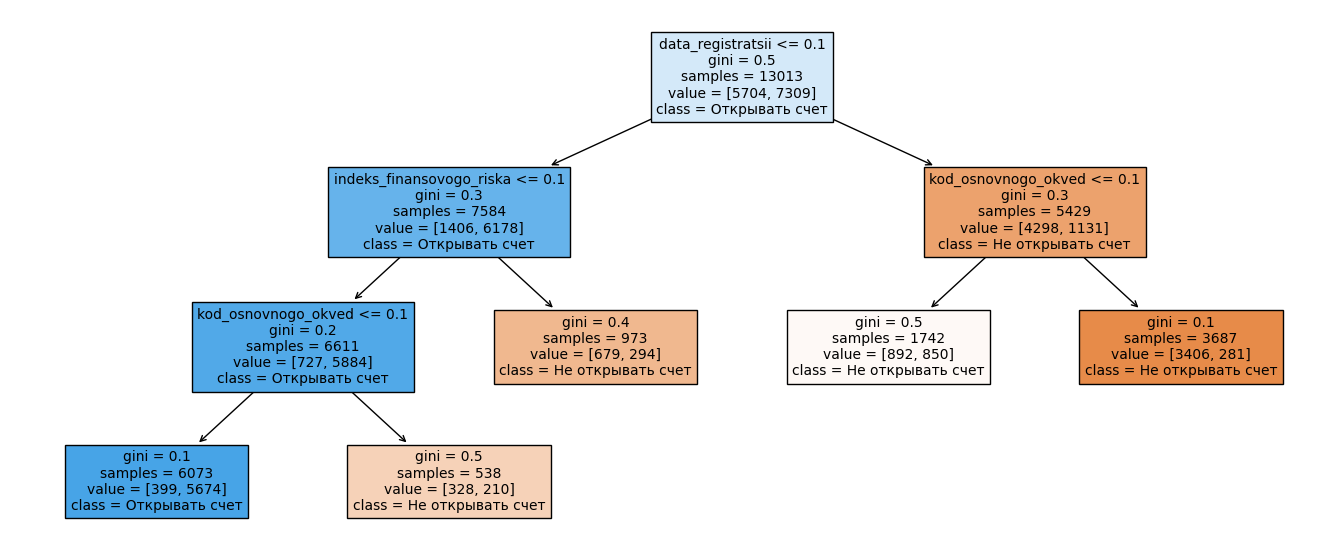

In [42]:
matplotlib.rc('figure', figsize=(17, 7))
tree.plot_tree(clf, 
               feature_names=list(X_test.columns),
               class_names=['Не открывать счет', 'Открывать счет'],
               filled=True,
               proportion = False,
               precision = 1,
               fontsize = 10)
plt.show()

**ВЫВОД:** 
- Мы видим, что обученное дерево использует 3 переменные для разделения данных и, таким образом, решает, следует ли открывать счет РКО.. .

### Задача 7: Что произойдет, если теперь штраф, когда банк открывает счет РКО клиенту, у которого закблокируется счет, равен -1? Что, если штраф станет еще меньше?

Далее мы определяем функцию ***runExperiment()***, которая позволит нам провести несколько экспериментов, варьируя штраф.

In [43]:
def run_experiment(clients: clients, agent: LinearBandits, N = 10_000, training_mode = True):
    """
    Эта функция запускает эксперимент для данного клиента и агента, что позволяет нам получить те же показатели, которые использовались ранее
        clients: соответствует классу клиентов;
        agent: соответствует агенту, использующему класс LinearBandits;
        N: соответствует первым N клиентам, над которыми агент выполняет действие;
        training_mode: Если True, веса (Q) агента обновляются в процессе.
    """
    # Reward
    reward_mean, reward_total, reward_total_vec = [], 0, []
    #Regret
    regret_mean, regret_total, regret_total_vec = [], 0, []

    # Линейный контекстный агент
    ag = agent

    for i in tqdm(range(N)):
        clients.clients()

        # Мы получаем контекст
        context = clients.get_context()

        # Выбираем действие по контексту
        action = ag.action(np.array(context))
        reward = clients.get_reward(action)

        # Обновляем модель
        if training_mode:
            ag.update(context, action, reward)

        reward_total += reward
        regret = clients.getBestReward()-reward
        regret_total += regret
        reward_mean.append(reward_total/(i+1)) # i+1 — количество итераций
        reward_total_vec.append(reward_total)
        regret_mean.append(regret_total/(i+1))
        regret_total_vec.append(regret_total)

    print("Reward mean:", reward_total/N)
    print("Regret mean:", regret_total/N)
    makePlots(reward_total_vec, reward_mean, regret_total_vec, regret_mean)

Тестируются 3 дополнительных значения штрафа [-1, -0,5, -0,1].

1. Штраф $-1$.).

100%|██████████| 10000/10000 [01:24<00:00, 118.41it/s]


Reward mean: 0.7654
Regret mean: 0.1228


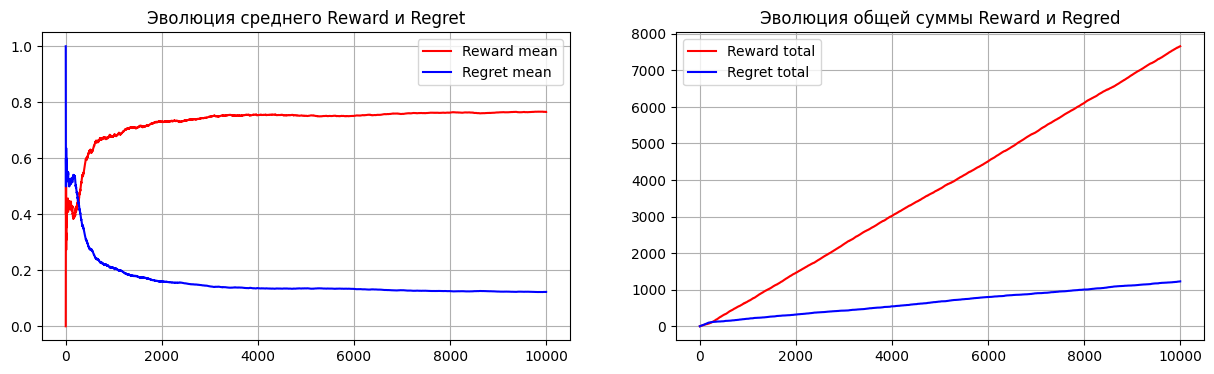

In [44]:
cl_train_2 = clients(df_train, context=feat_cols, target=target, penalty=-1)
lb2 = LinearBandits(len(available_actions), n_feats, initial_pulls=100)
matplotlib.rc('figure', figsize=(15, 4))
run_experiment(cl_train_2, lb2)

**ВЫВОД:** Видно, что модель явно улучшилась, потому что за счет уменьшения штрафа у нас появляется более «рискованный» агент при открытии счетов РКО. То есть, в отличие от предыдущей модели, этот агент открывает большее счетов (что делает его менее чувствительным к контексту).

---
2. Штраф $-0,5$. .

100%|██████████| 10000/10000 [01:28<00:00, 113.03it/s]


Reward mean: 0.82225
Regret mean: 0.06595


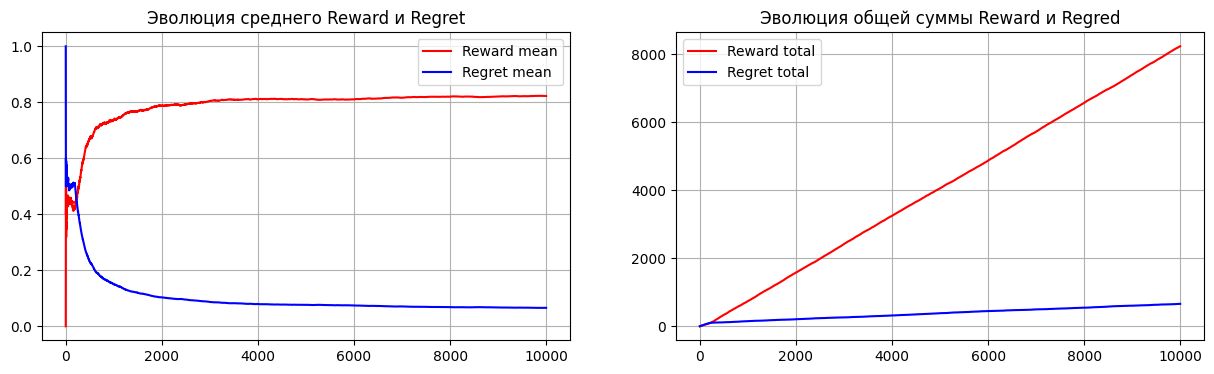

In [45]:
cl_train_3 = clients(df_train, context=feat_cols, target=target, penalty=-0.5)
lb3 = LinearBandits(len(available_actions), n_feats, initial_pulls=100)
matplotlib.rc('figure', figsize=(15, 4))
run_experiment(cl_train_3, lb3)

---
3. Штраф $-0,1$е.

100%|██████████| 10000/10000 [01:17<00:00, 128.30it/s]


Reward mean: 0.8667999999999821
Regret mean: 0.02139999999999937


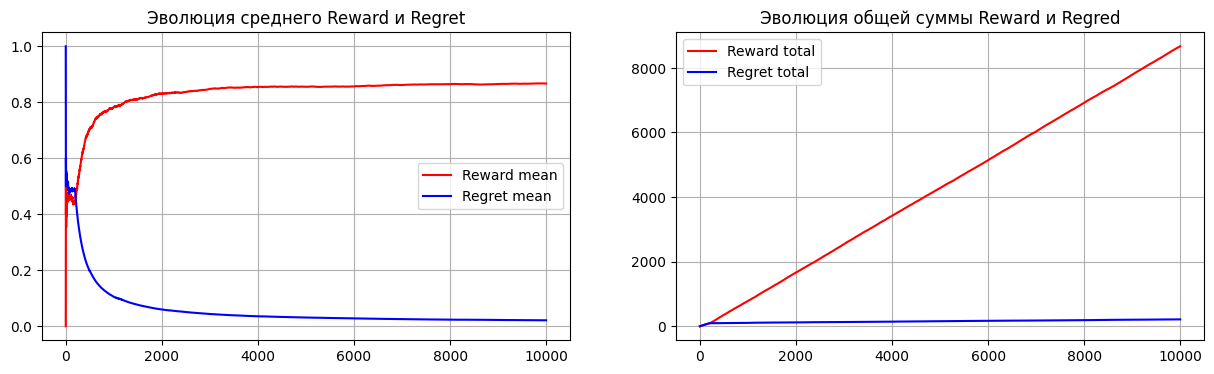

In [46]:
cl_train_4 = clients(df_train, context=feat_cols, target=target, penalty=-0.1)
lb4 = LinearBandits(len(available_actions), n_feats, initial_pulls=100)
matplotlib.rc('figure', figsize=(15, 4))
run_experiment(cl_train_4, lb4)


**ВЫВОД:** Аналогично, снижая штраф дальше, мы видим, что **Reward** имеет тенденцию к улучшению. Важно учитывать, что мы работаем с очень несбалансированным набором данных (имеем мало клиентов по умолчанию $11$%), поэтому в этом случае сильное снижение штрафа (даже до нуля) не сильно наказывается, поэтому лучше всегда открывать счет. Однако при более сбалансированном наборе данных (и в реальной жизни) слишком сильное снижение штрафа может отрицательно повлиять на **Reward**.

*Более того, если мы сравним эту модель с алгоритмом, который всегда открывает счет (со штрафом в размере -0.1), мы увидим, что получим аналогичные результаты. В данном конкретном примере выбор соответствующего наказания имеет важное значение.*

### Задача 8: Оптимизируйте свою систему, выбрав переменные.

Затем мы получаем копию набора обучающих данных.

In [47]:
X_train = df_train[feat_cols].copy()
y_train = df_train[target]
print(df_train.shape)
df_train.head()

(39036, 83)


,idinquiry,time_zajavki,tip_organizatsii,data_zajavki,year_mon_zajavki,quarter_zajavki,year_zajavki,inn,time_zagruzki_zajavki,kolichestvo_kompanij_s_analogichnym_direktorom_v_tom_zhe_regione,...,tax_profit,kmeans_2,kmeans_3,kmeans_4,kmeans_5,kmeans_6,kmeans_7,kmeans_8,kmeans_9,kmeans_10
29629,248409,2019-02-06 15:00:00.000000,ЮЛ,2019-02-06,2019-02,2019Q1,2019,CQUBOCDWRR,2019-02-06 14:58:26.337000,4.0,...,-0.395848,0.087584,0,0,0.083471,2,4,4,0.097503,0.096147
32044,255043,2019-02-18 11:08:59.999999,ИП,2019-02-18,2019-02,2019Q1,2019,YYCPJJASKBGT,2019-02-18 10:59:42.267000,0.0,...,-0.395848,0.092998,2,1,0.092545,0,1,0,0.086852,0.087452
47746,311578,2019-04-19 14:15:00.000000,ЮЛ,2019-04-19,2019-04,2019Q2,2019,ZJYEAPULIV,2019-04-19 14:15:07.960000,1.0,...,2.526220,0.110187,0,0,0.136602,2,4,4,0.124500,0.136751
9249,180823,2018-09-18 10:37:00.000000,ЮЛ,2018-09-18,2018-09,2018Q3,2018,UHAGVVTRWB,2018-09-18 10:23:11.317000,2.0,...,-0.395848,0.022715,0,0,0.025507,2,4,4,0.028479,0.026397
51572,510475,2019-10-07 12:48:00.000000,ИП,2019-10-07,2019-10,2019Q4,2019,GLDSPGXBUPDD,2019-10-07 12:47:32.050000,0.0,...,-0.395848,0.113472,2,1,0.144951,0,1,0,0.103691,0.145043


Мы получаем действия, предпринятые агентом (со штрафом в $-1$) для обучающих данных.

In [48]:
taked_actions = []
for i in range(len(X_train)):
    context = X_train.iloc[i]
    action = lb2.action(np.array(context))
    taked_actions.append(action)
print('Всего предпринятых действий:',len(taked_actions))

Всего предпринятых действий: 39036


Теперь мы обучаем случайный лес (суррогатную модель) для получения наиболее важных переменных для агента.

In [49]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=SEED)
forest.fit(X_train, taked_actions)

RandomForestClassifier(random_state=42)

Text(0, 0.5, 'Среднее уменьшение примесей')

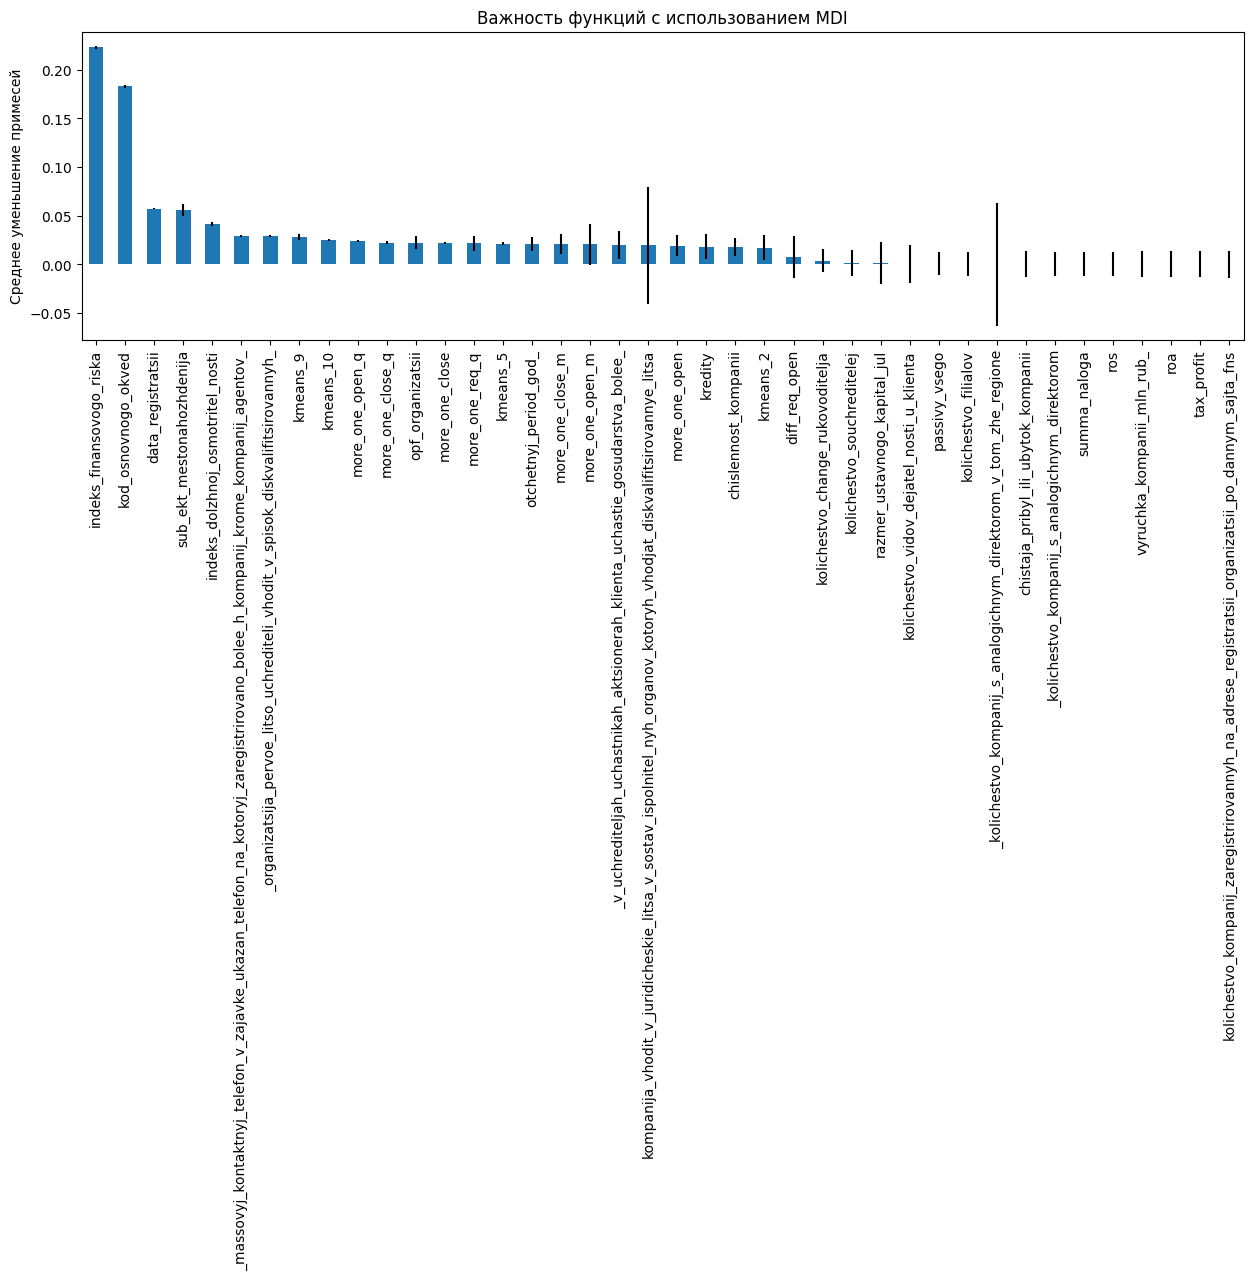

In [50]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Важность функций с использованием MDI")
ax.set_ylabel("Среднее уменьшение примесей")

Мы берем порог с целью взять наиболее важные переменные, в данном случае мы решили сохранить переменные приняв порог 0.05.

In [51]:
mdi_threshold = 0.05
fs = forest_importances[forest_importances >= mdi_threshold]
fs

indeks_finansovogo_riska     0.223337
kod_osnovnogo_okved          0.182941
data_registratsii            0.057289
sub_ekt_mestonahozhdenija    0.055956
dtype: float64

In [52]:
fs_index =  ['target'] + list(fs.index)
df_train_selected = df_train.copy()
df_train_selected = df_train_selected[fs_index]
df_train_selected.head()

,target,indeks_finansovogo_riska,kod_osnovnogo_okved,data_registratsii,sub_ekt_mestonahozhdenija
29629,0,0.086790,0.060153,0.008069,0.074696
32044,0,0.068214,0.031799,0.191304,0.096471
47746,0,0.147723,0.002173,0.065959,0.121177
9249,0,0.004519,0.000422,0.003896,0.070432
51572,0,0.087089,0.139121,0.194669,0.145163


Мы запускаем эксперимент с обучающими данными (с выбранными переменными) и со штрафом $-3$.

100%|██████████| 10000/10000 [00:46<00:00, 215.14it/s]


Reward mean: 0.577
Regret mean: 0.3112


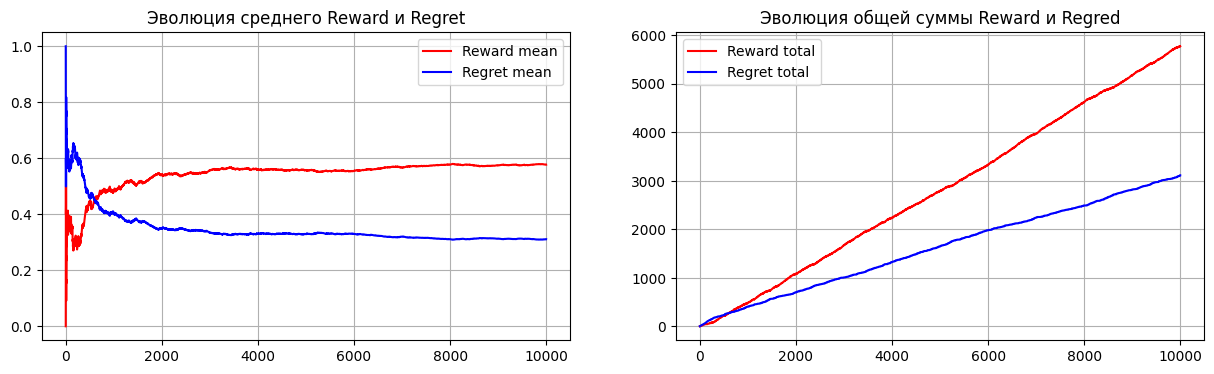

In [53]:
cl_selected = clients(df_train_selected, context=fs.index, target=target, penalty=-3)
lb_selected = LinearBandits(len(available_actions), len(fs_index) - 1 , initial_pulls=100)
run_experiment(cl_selected, lb_selected)

**ОТВЕТ:** 
- Как видно из показателей и графиков (в данных обучения), представленных при использовании первых наиболее важных переменных, производительность агента сохраняется. То есть, несмотря на уменьшение количества используемых переменных, производительность агента не пострадает. Используя меньше переменных, модель становится более эффективной (за счет выполнения оптимизации).

Теперь можно увидеть результаты оптимизированной модели на тестовых данных. Полученные результаты согласуются с результатами, полученными при обучении, сохраняя немного лучшие показатели вознаграждения и сожаления, чем при обучении, это подтверждает, что наша модель выполняет адекватную работу.

100%|██████████| 10000/10000 [00:19<00:00, 526.31it/s]


Reward mean: 0.5797
Regret mean: 0.3044


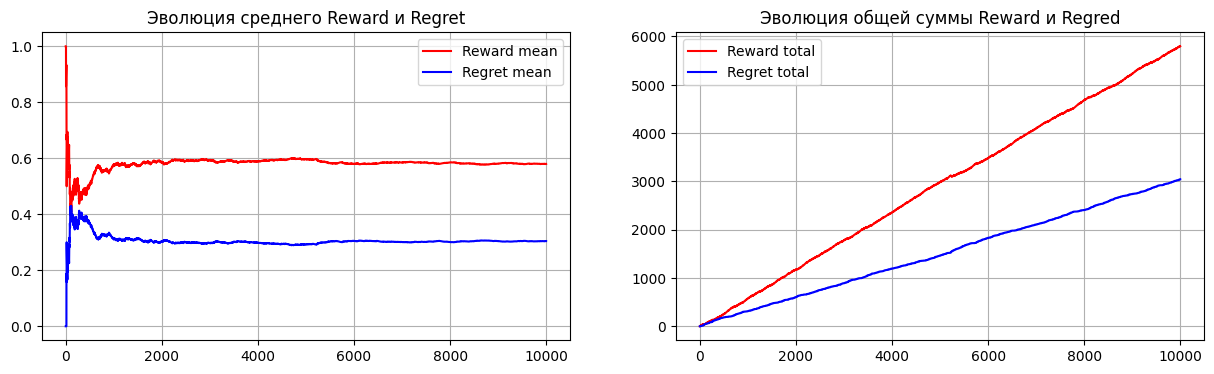

In [54]:
cl_selected_test = clients(df_test[fs_index], context=fs.index, target=target, penalty=-3)
run_experiment(cl_selected_test, lb_selected, training_mode=False)

Дополнительно на тестовых данных проводится анализ действий агента.

In [55]:
taked_actions = []
res = []
for i in tqdm(range(len(X_test))):
    context = X_test.iloc[i][fs_index[1:]]
    action = lb_selected.action(np.array(context))
    taked_actions.append(action)
    if action == 1:# открыть РКО счет
        if y_test[i] == 0: # счет не был заблокирован
            res.append('Открывать')
        else:# счет был заблокирован
            res.append('Не открывать')
    else: # не открывать РКО счет
        if y_test[i] == 0: # счет не был заблокирован
            res.append('Открывать')
        else:# счет был заблокирован
            res.append('Не открывать')


print('Всего предпринятых действий:',len(taked_actions))

100%|██████████| 13013/13013 [00:22<00:00, 587.12it/s]

Всего предпринятых действий: 13013


In [56]:
results = pd.DataFrame({'Действие': taked_actions, 'Результат': res})

general_res = results.groupby(['Действие']).size().reset_index(name='Количество')
general_res['Процент'] = general_res['Количество'] * 100 / len(taked_actions)
general_res

,Действие,Количество,Процент
0,0,1071,8.230231
1,1,11942,91.769769


**99% клиентам открыли счет**

In [57]:
general_res_2 = results.groupby(['Действие', 'Результат']).size().reset_index(name='Значение')
general_res_2.pivot(index='Действие', columns='Результат', values='Значение')

Результат,Не открывать,Открывать
Действие,,
0,395,676
1,1075,10867


Далее мы рассчитываем стоимость упущенной возможности.:

$$\textrm{Стоимость упущенной возможности} = \textrm{Ценность принесенного в жертву лучшего действия} - \textrm{Стоимость выбранной акции} .$$

In [58]:
best_actions = [1 if x == 0 else 0 for x in y_test] # Мы инвертируем y_test так, чтобы 1 представляло действие, которое должно было быть выполнено (основная истина).
lost_opportunity_cost = [x - y for x, y in zip(best_actions, taked_actions)]
print('Стоимость упущенной возможности: ', np.sum(lost_opportunity_cost))

Стоимость упущенной возможности:  -399


Теперь мы показываем матрицу путаницы лучших действий (обратных переменной _target_) и действий, предпринятых агентом.

Text(0.5, 1.0, 'Conf матрица')

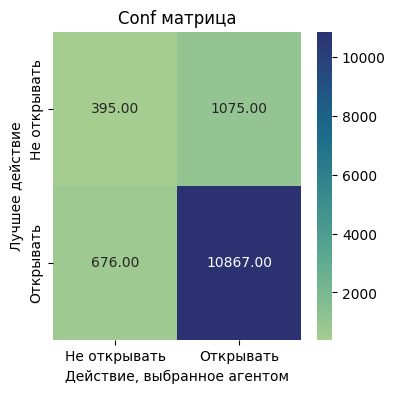

In [59]:
matplotlib.rc('figure', figsize=(4, 4))

df_cm = pd.DataFrame(confusion_matrix(best_actions, taked_actions))
df_cm.columns = ['Не открывать', 'Открывать']
df_cm.index  = ['Не открывать', 'Открывать']
sn.heatmap(df_cm, annot=True, fmt=".2f", cmap="crest")
plt.xlabel('Действие, выбранное агентом')
plt.ylabel('Лучшее действие')
plt.title('Conf матрица')

In [60]:
print(classification_report(best_actions, taked_actions))

              precision    recall  f1-score   support

           0       0.37      0.27      0.31      1470
           1       0.91      0.94      0.93     11543

    accuracy                           0.87     13013
   macro avg       0.64      0.61      0.62     13013
weighted avg       0.85      0.87      0.86     13013



In [61]:
fs.index

Index(['indeks_finansovogo_riska', 'kod_osnovnogo_okved', 'data_registratsii',
       'sub_ekt_mestonahozhdenija'],
      dtype='object')